# Dimension reduction using entropy

--------

**Problem:** Is it possible to reduce the dataset complexity using simple entropy?

Inspired by https://doi.org/10.3390/e23121621.

Palmer penguin dataset from https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data.

Classifiers are limited to those using DTs (CART, Bagging, AdaBoost and Random Forest).

## Data preprocessing

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import math

penguins = pd.read_csv('penguins_size.csv')
penguins.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [17]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [18]:
# removing rows with NaN
penguins.dropna(inplace = True)

In [19]:
# check content of text columns
penguins['island'].value_counts()

Biscoe       164
Dream        123
Torgersen     47
Name: island, dtype: int64

In [20]:
penguins['sex'].value_counts()

MALE      168
FEMALE    165
.           1
Name: sex, dtype: int64

In [21]:
# removing row with '.'
penguins = penguins[penguins['sex'] != '.']

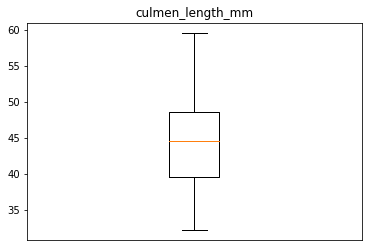

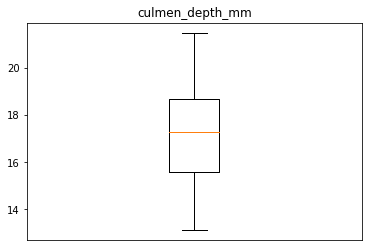

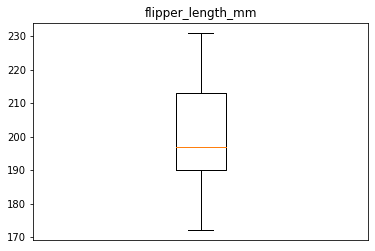

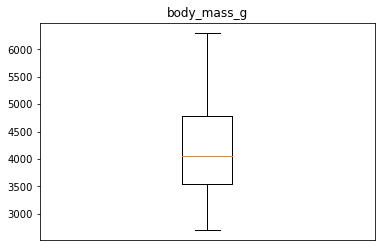

In [22]:
# checking for outliers
num_cols = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']

for col in num_cols:
    plt.boxplot(penguins[col])
    plt.title(col)
    plt.xticks([])
    plt.show()

<AxesSubplot:>

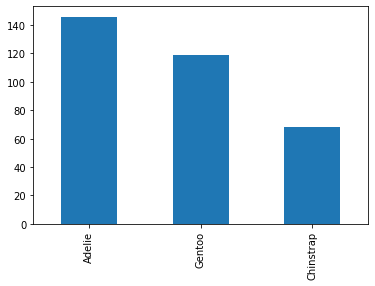

In [23]:
# checking distribution of decision classes
penguins['species'].value_counts().plot(kind='bar')
# results can be skewed due to uneven distribution of decision classes in the dataset

In [24]:
# turning strings into numbers
cat_cols = ['island', 'sex']
le = LabelEncoder()
penguins[cat_cols] = penguins[cat_cols].apply(le.fit_transform)

<AxesSubplot:>

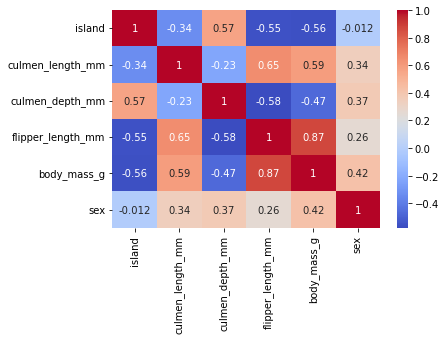

In [25]:
# looking for correlations 
corr = penguins.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, cmap='coolwarm', annot=True)
# there is strong correlation between body mass and flipper length - one of them can be dropped

In [26]:
# discretization of continuous features
for col in num_cols:
    penguins[col] = pd.cut(penguins[col], 10, labels=[i for i in range(10)]).astype('int')

## Entropy and information functions

In [27]:
def entropy(df):
    col_size = df['species'].size
    entropy = 0
    for value in df['species'].unique():
        p = df['species'].value_counts()[value]/col_size
        if p != 0:
            entropy -= p * math.log(p, 2)
    return entropy

def info(df, col):
    col_size = df[col].size
    result = 0
    for value in df[col].unique():
        count = df[col].value_counts()[value]
        local_entropy = 0
        for dec_class in df['species'].unique():
            local_count = df[(df['species'] == dec_class) & (df[col] == value)]['species'].count()
            p = local_count/count
            if p != 0:
                local_entropy -= p * math.log(p, 2)
        result += local_entropy * count/col_size
    return result

print('Entropy:', round(entropy(penguins), 2))
print('Max entropy for 3 classes:', round(math.log(3, 2), 2))
print('\nInformation function:')
for col in penguins:
    if col != 'species':
        print('{} - {}'.format(col, round(info(penguins, col), 2)))

Entropy: 1.52
Max entropy for 3 classes: 1.58

Information function:
island - 0.78
culmen_length_mm - 0.72
culmen_depth_mm - 0.75
flipper_length_mm - 0.62
body_mass_g - 0.8
sex - 1.52


In [28]:
# spliting the dataset 
X_all = penguins.drop('species', axis = 1) # based on all attributes
X_low = penguins[['culmen_length_mm', 'flipper_length_mm']] # based on 2 attributes with the lowest information function
X_high = penguins[['body_mass_g', 'sex']] # based on 2 attributes with the highest information function

X_dict = {
    'all atrributes' : X_all,
    '2 attributes with the lowest information function' : X_low, 
    '2 attributes with the highest information function' : X_high
}

y = penguins['species']

## Learning and evaluation steps

In [29]:
from sklearn import tree 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from datetime import datetime

classifiers = {}

# classifiers['Decision Tree (no pruning)'] = tree.DecisionTreeClassifier()
classifiers['Decision Tree (with pruning)'] = tree.DecisionTreeClassifier(max_depth = 3)
classifiers['Bagging'] = BaggingClassifier()
classifiers['AdaBoost'] = AdaBoostClassifier()
# classifiers['Random Forest (no pruning)'] = RandomForestClassifier()
classifiers['Random Forest (with pruning)'] = RandomForestClassifier(max_depth = 3, n_estimators = 100)

summary = {}
for var, X in X_dict.items():
    results = {}
    for clf_name in classifiers:
        # start of execution time measurement
        start_time = datetime.now()

        print('------------------------------')
        print(clf_name)
        print(var)
        clf = classifiers[clf_name]

        # T&T validation
#         X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = 0.4) 
#         clf.fit(X_tr, y_tr)
#         y_pred = clf.predict(X_te) 
#         print(confusion_matrix(y_te, y_pred))

#         accuracy = accuracy_score(y_te, y_pred)
#         recall = list(recall_score(y_te, y_pred, average = None))
#         precision = list(precision_score(y_te, y_pred, average = None))

        # k-cross validation
        y_pred = cross_val_predict(clf, X, y, cv = 10)
        print()
        print(confusion_matrix(y, y_pred))
        print()

        accuracy = accuracy_score(y, y_pred)
        recall = list(recall_score(y, y_pred, average=None, zero_division = 0))
        precision = list(precision_score(y, y_pred, average=None, zero_division = 0))

        # execution time measurement
        td = datetime.now() - start_time
        duration = td.total_seconds()
        print('Execution time: {:.2f} sec\n'.format(duration))

        results[clf_name] = [accuracy, recall, precision, duration]
    summary[var] = results

------------------------------
Decision Tree (with pruning)
all atrributes

[[140   4   2]
 [  5  63   0]
 [  2   0 117]]

Execution time: 0.11 sec

------------------------------
Bagging
all atrributes

[[141   5   0]
 [  1  67   0]
 [  0   1 118]]

Execution time: 0.52 sec

------------------------------
AdaBoost
all atrributes

[[143   2   1]
 [ 24  44   0]
 [  1   0 118]]

Execution time: 1.78 sec

------------------------------
Random Forest (with pruning)
all atrributes

[[140   6   0]
 [  4  64   0]
 [  0   0 119]]

Execution time: 2.67 sec

------------------------------
Decision Tree (with pruning)
2 attributes with the lowest information function

[[138   6   2]
 [  4  62   2]
 [  0   6 113]]

Execution time: 0.07 sec

------------------------------
Bagging
2 attributes with the lowest information function

[[137   7   2]
 [  8  55   5]
 [  0   3 116]]

Execution time: 0.41 sec

------------------------------
AdaBoost
2 attributes with the lowest information function

[[139  

## Visualisation of the results

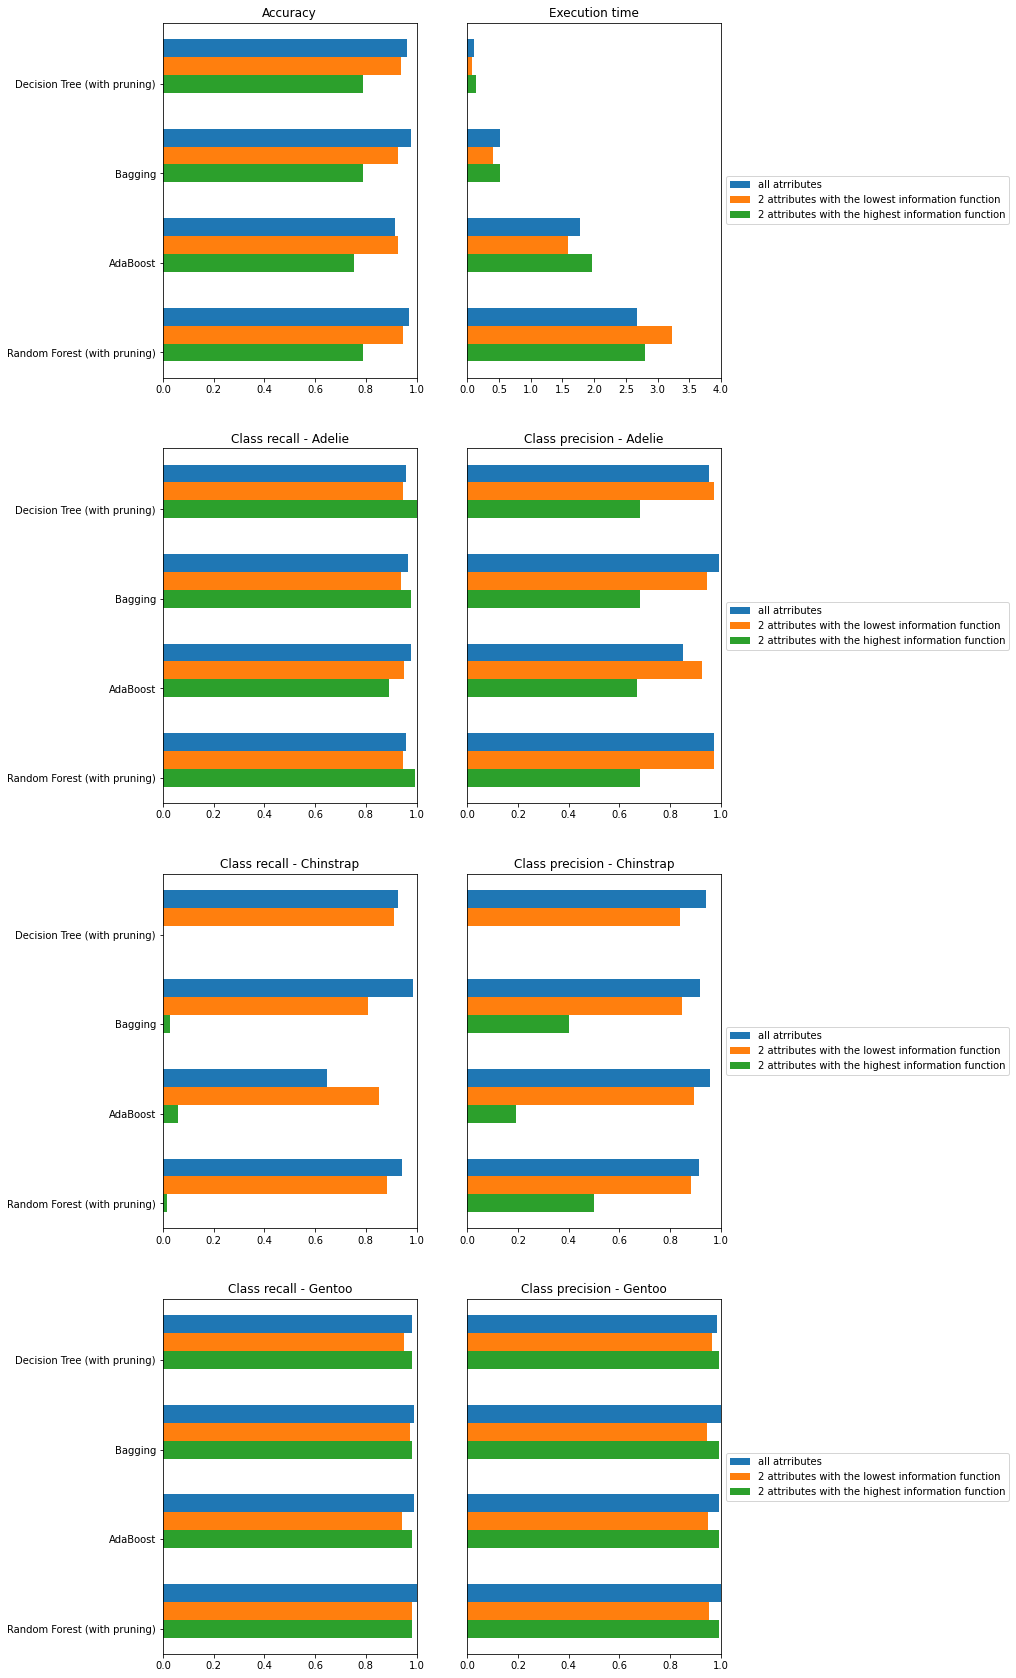

In [30]:
import numpy as np

classes = y.unique()
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize = (10, 30))
counter = 0

for var, results in summary.items():    
    labels = [clf_name for clf_name in results]
    
    accuracy = [results[clf_name][0] for clf_name in results]
    
    recall_1 = [results[clf_name][1][0] for clf_name in results]
    recall_2 = [results[clf_name][1][1] for clf_name in results]
    recall_3 = [results[clf_name][1][2] for clf_name in results]
    
    precision_1 = [results[clf_name][2][0] for clf_name in results]
    precision_2 = [results[clf_name][2][1] for clf_name in results]
    precision_3 = [results[clf_name][2][2] for clf_name in results]
    
    duration = [results[clf_name][3] for clf_name in results]
    
    x = np.arange(len(labels))  
    width = 0.2

    ax1.barh(x + width*counter, accuracy, width, tick_label=labels, label=var)
    ax2.barh(x + width*counter, duration, width, tick_label=labels, label=var)
    ax3.barh(x + width*counter, recall_1, width, tick_label=labels, label=var)
    ax4.barh(x + width*counter, precision_1, width, tick_label=labels, label=var)
    ax5.barh(x + width*counter, recall_2, width, tick_label=labels, label=var)
    ax6.barh(x + width*counter, precision_2, width, tick_label=labels, label=var)
    ax7.barh(x + width*counter, recall_3, width, tick_label=labels, label=var)
    ax8.barh(x + width*counter, precision_3, width, tick_label=labels, label=var)

    counter += 1
    
ax1.invert_yaxis()
ax1.set_title('Accuracy')
ax1.set_xlim([0, 1])
# ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax2.invert_yaxis()
ax2.set_title('Execution time')
ax2.set_xlim([0, 4])
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.get_yaxis().set_visible(False)

ax3.invert_yaxis()
ax3.set_title('Class recall - ' + str(classes[0]))
ax3.set_xlim([0, 1])
# ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax4.invert_yaxis()
ax4.set_title('Class precision - ' + str(classes[0]))
ax4.set_xlim([0, 1])
ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax4.get_yaxis().set_visible(False)

ax5.invert_yaxis()
ax5.set_title('Class recall - ' + str(classes[1]))
ax5.set_xlim([0, 1])
# ax5.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax6.invert_yaxis()
ax6.set_title('Class precision - ' + str(classes[1]))
ax6.set_xlim([0, 1])
ax6.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax6.get_yaxis().set_visible(False)

ax7.invert_yaxis()
ax7.set_title('Class recall - ' + str(classes[2]))
ax7.set_xlim([0, 1])
# ax7.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax8.invert_yaxis()
ax8.set_title('Class precision - ' + str(classes[2]))
ax8.set_xlim([0, 1])
ax8.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax8.get_yaxis().set_visible(False)

plt.show()

## Summary

- All classifiers predict wit similar accuracy. However, the more complicated classifier, the longer the execution time.
- Metrics of a model based on dataset limited to 2 attributes with the lowest entropy have been similar to results obtained with full dataset as expected.
- Models which based on limited datasets the metrics for Chinstrap class are worst then those achieved for other classes. It may be the effect of uneven class distribution (Chinstrap is only about 20% of the dataset).